In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

data = np.loadtxt("trajectory.txt", converters = {1: lambda s: b"O" == s})
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
times = np.unique(data[:,0])
def get_data(n):
    timeslice = data[data[:,0] == times[n]]
    is_oxygen = timeslice[:,1] == 1
    return timeslice[is_oxygen,2:], timeslice[~is_oxygen,2:]
data_0 = get_data(0)
oxygen_pts = ax.scatter(*data_0[0].T, c = 'b', marker='o')
hydrogen_pts = ax.scatter(*data_0[1].T, c = 'k', marker='o')

# don't show the plain background
plt.close()

# define function to draw each frame
def drawframe(n):
    if n % 10 == 1:
        print(f"Drawing frame {n} of {len(times)}")
    data_slice = get_data(n)
    oxygen_pts._offsets3d = data_slice[0].T
    hydrogen_pts._offsets3d = data_slice[1].T
    return oxygen_pts, hydrogen_pts

anim = animation.FuncAnimation(fig, drawframe, frames=len(times), interval=20, blit=True)

In [ ]:
# save movie to file
anim.save("video.gif")

In [ ]:
# interactive applet
from IPython.display import HTML
HTML(anim.to_jshtml())

In [28]:
import re
import pandas as pd
import matplotlib.pyplot as plt

def parse_gprof(file_path):
    data = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    parsing = False
    for line in lines:
        if 'Flat profile:' in line:
            parsing = True
            continue
        if parsing and re.match(r"\s*\d+\.\d+", line):
            parts = line.split()
            if len(parts) > 6:
                percent_time = float(parts[0])
                cumulative_seconds = float(parts[1])
                self_seconds = float(parts[2])
                calls = int(parts[3]) if parts[3].isdigit() else None
                us_per_call_self = float(parts[4]) if parts[4].replace('.', '', 1).isdigit() else None
                us_per_call_total = float(parts[5]) if parts[5].replace('.', '', 1).isdigit() else None
                function_name = ' '.join(parts[6:])
                
                data.append([percent_time, cumulative_seconds, self_seconds, calls, us_per_call_self, us_per_call_total, function_name])
    
    df = pd.DataFrame(data, columns=["% time", "cumulative seconds", "self seconds", "calls", "us/call (self)", "us/call (total)", "name"])
    return df


n mol: 10


,% time,cumulative seconds,self seconds,calls,us/call (self),us/call (total),name
0,80.0,0.08,0.08,10000,8.0,8.0,UpdateNonBondedForces(System&)
1,20.0,0.10,0.02,10000,2.0,2.0,UpdateAngleForces(System&)
3,0.0,0.10,0.00,10000,0.0,0.0,UpdateBondForces(System&)
6,0.0,0.10,0.00,100,0.0,0.0,BuildNeighborList(System&)


n mol: 100


,% time,cumulative seconds,self seconds,calls,us/call (self),us/call (total),name
0,92.93,0.92,0.92,10000,92.0,92.0,UpdateNonBondedForces(System&)
1,4.04,0.96,0.04,10000,4.0,4.0,UpdateAngleForces(System&)
3,1.01,0.99,0.01,10000,1.0,1.0,UpdateBondForces(System&)
7,0.00,0.99,0.00,100,0.0,200.0,BuildNeighborList(System&)


n mol: 1000


,% time,cumulative seconds,self seconds,calls,us/call (self),us/call (total),name
0,83.25,8.00,8.00,10000,0.80,0.80,UpdateNonBondedForces(System&)
1,5.31,8.51,0.51,10000,0.05,0.05,UpdateAngleForces(System&)
2,3.95,8.89,0.38,100,3.80,6.40,BuildNeighborList(System&)
3,2.91,9.17,0.28,10000,0.03,0.03,UpdateBondForces(System&)


Error processing vec_10000.txt: [Errno 2] No such file or directory: 'vec_10000.txt'


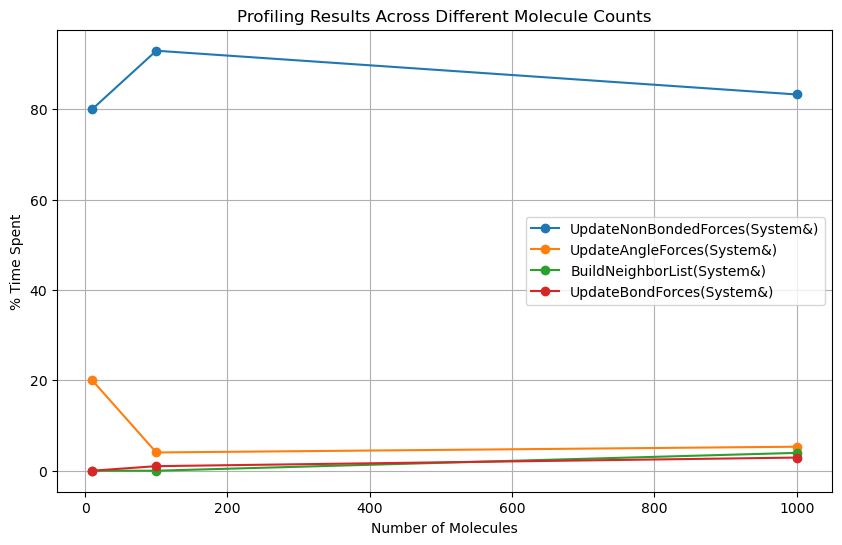

In [35]:
def parse_gprof(file_path):
    data = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    parsing = False
    for line in lines:
        if 'Flat profile:' in line:
            parsing = True
            continue
        if parsing and re.match(r"\s*\d+\.\d+", line):
            parts = line.split()
            if len(parts) > 6:
                percent_time = float(parts[0])
                cumulative_seconds = float(parts[1])
                self_seconds = float(parts[2])
                calls = int(parts[3]) if parts[3].isdigit() else None
                us_per_call_self = float(parts[4]) if parts[4].replace('.', '', 1).isdigit() else None
                us_per_call_total = float(parts[5]) if parts[5].replace('.', '', 1).isdigit() else None
                function_name = ' '.join(parts[6:])
                
                data.append([percent_time, cumulative_seconds, self_seconds, calls, us_per_call_self, us_per_call_total, function_name])
    
    df = pd.DataFrame(data, columns=["% time", "cumulative seconds", "self seconds", "calls", "us/call (self)", "us/call (total)", "name"])
    return df
function_names = ['UpdateNonBondedForces(System&)', 'UpdateAngleForces(System&)', 'BuildNeighborList(System&)', 'UpdateBondForces(System&)']
data = {func: [] for func in function_names}
n_mols = [10, 100, 1000, 10000]
used_n_mol = []
for n_mol in n_mols:
    try:
        profile_path = f"vec_{n_mol}.txt"
        df = parse_gprof(profile_path)
        df = df[df["name"].isin(function_names)]
        print("n mol:", n_mol)
        display(d)
        for func in function_names:
            func_time = df[df["name"] == func]["% time"].values
            data[func].append(func_time[0] if len(func_time) > 0 else 0)
        used_n_mol.append(n_mol)
    except Exception as e:
        print(f"Error processing {profile_path}: {e}")

plt.figure(figsize=(10, 6))
for func, times in data.items():
    plt.plot(used_n_mol, times, marker='o', label=func)

plt.xlabel("Number of Molecules")
plt.ylabel("% Time Spent")
plt.title("Profiling Results Across Different Molecule Counts")
plt.legend()
plt.grid()
plt.show()



In [25]:
trial = data[0][1][['% time', 'name']].loc[[] != 0]

trial



TypeError: list indices must be integers or slices, not str

In [26]:
[data['% time'] != 0]

TypeError: list indices must be integers or slices, not str